# `u8timeseries` Intro

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from u8timeseries import TimeSeries

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## `TimeSeries` Creation
### From a `pd.Series`:

In [3]:
pdseries = pd.Series(np.sin(range(30)), index=pd.date_range('20130101', '20130130'))
series = TimeSeries(pdseries)

### From a `pd.DataFrame`:

In [4]:
df = pd.DataFrame({'Date': pd.date_range('20130101', '20130130'), 'Value': np.sin(range(30))})

df.head()

,Date,Value
0,2013-01-01,0.000000
1,2013-01-02,0.841471
2,2013-01-03,0.909297
3,2013-01-04,0.141120
4,2013-01-05,-0.756802


In [5]:
series = TimeSeries.from_dataframe(df, time_col='Date', value_col='Value')

### From times and values directly:

In [6]:
series = TimeSeries.from_times_and_values(pd.date_range('20130101', '20130130'), np.sin(range(30)))

## More on `TimeSeries`
### Plotting
wrapper around `pd.Series.plot()`

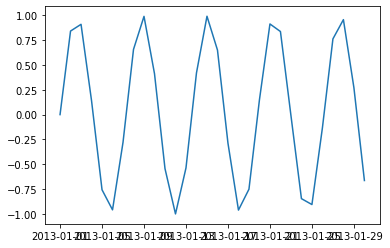

In [7]:
series.plot()

### Confidence Intervals

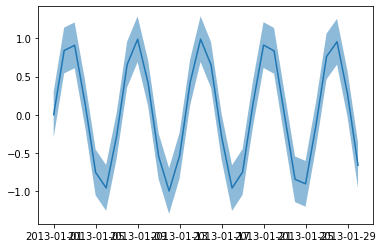

In [8]:
pdseries_low = pd.Series(np.sin(range(30)) - 0.3, index=pd.date_range('20130101', '20130130'))
pdseries_up = pd.Series(np.sin(range(30)) + 0.3, index=pd.date_range('20130101', '20130130'))

series_conf = TimeSeries(pdseries, pdseries_low, pdseries_up)

series_conf.plot()

### Drop, Slice, split

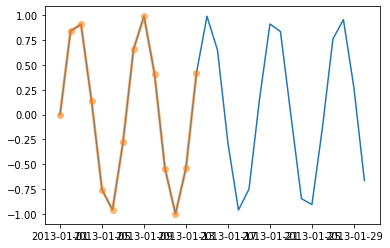

In [9]:
# Drop end:
series.plot()
beginning = series.drop_after(pd.Timestamp('20130115'))
beginning.plot(marker='o', lw=3, alpha=0.5)

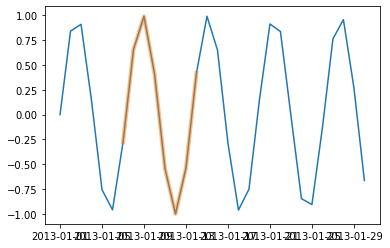

In [10]:
# Slice
subseries = series.slice(pd.Timestamp('20130107'), pd.Timestamp('20130114'))
series.plot()
subseries.plot(lw=4, alpha=0.5)

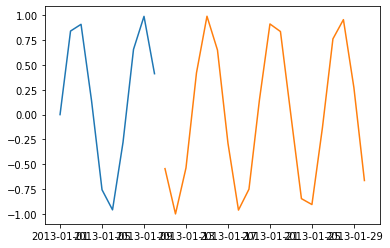

In [11]:
# Split
s1, s2 = series.split_after(pd.Timestamp('20130110'))
s1.plot()
s2.plot()

### Intersect (in time)

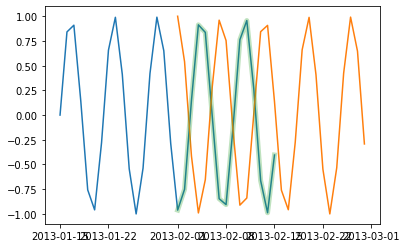

In [12]:
series1 = TimeSeries(pd.Series(np.sin(range(32)), index=pd.date_range('20130115', '20130215')))
series2 = TimeSeries(pd.Series(np.cos(range(28)), index=pd.date_range('20130201', '20130228')))

series1.plot()
series2.plot()

slice_index = series1.intersect(series2)
series1[slice_index].plot(lw=5, alpha=0.3)

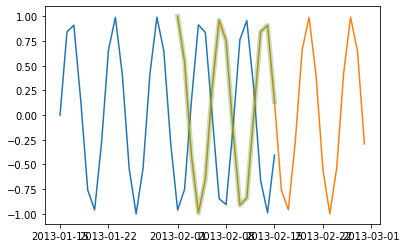

In [13]:
series1.plot()
series2.plot()

series2[slice_index].plot(lw=5, alpha=0.3)

# Auto-regressive Models

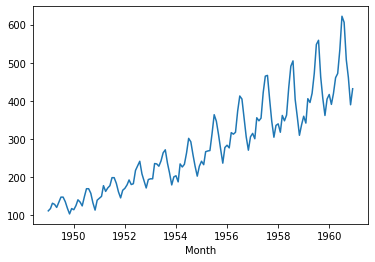

In [14]:
df = pd.read_csv('AirPassengers.csv')
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
series.plot()

In [15]:
from u8timeseries import ExponentialSmoothing

train, val = series.split_after(pd.Timestamp('19580101'))

model = ExponentialSmoothing()
model.fit(train)
pred_val = model.predict(len(val))

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



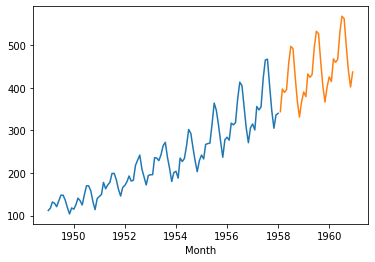

In [16]:
train.plot()
pred_val.plot()

### Backtesting

In [17]:
from u8timeseries.backtesting import simulate_forecast_ar

historical_fcast = simulate_forecast_ar(series, model, pd.Timestamp('19570601'), fcast_horizon_n=6, verbose=True)

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



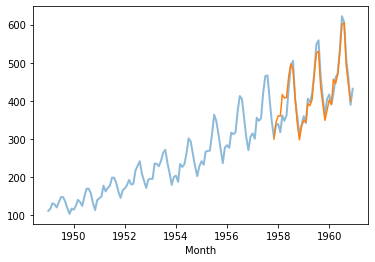

In [18]:
series.plot(lw=2, alpha=0.5)
historical_fcast.plot()

In [19]:
from u8timeseries.metrics import mape, mase

slice_series = series.intersect(historical_fcast)
mape(series[slice_series], historical_fcast[slice_series])

4.457910001033541